***How to Do Experiment Tracking:***

1. Go to the VS Code Terminal.
2. Ensure the Conda environment is active.
3. Navigate to the root directory of the project (where the mlruns folder is located).
4. Type the command `mlflow ui` and hit Enter.
5. See a message saying "Serving on http://127.0.0.1:5000".
6. Ctrl + Click that link (or open a web browser and type http://localhost:5000).

# 3.1 Business Assumptions 

The datasets used in this project were obtained from a Sri Lankan Telco company. Hence, these general estimates were derived from **Dialog Axiata’s FY2024 Financial Statements** and **TRCSL (Telecommunications Regulatory Commission of Sri Lanka)** official reports.

## Data Sources & References:

  * **Revenue & Subscriber Base:**

      * **Source:** *Dialog Axiata PLC Annual Report 2024*.
      * **Data:** Revenue of **Rs. 171.17 Billion** and a total subscriber base of **19.1 Million**.
      * **Link:** [Dialog Axiata PLC Annual Report 2024 (Colombo Stock Exchange)](https://cdn.cse.lk/cmt/upload_report_file/389_1747616410421.pdf)

  * **Prepaid vs. Postpaid Split (92% Prepaid):**

      * **Source:** *Dialog Axiata Fact Sheet (2024)*.
      * **Data:** 17.5M Prepaid users vs. 1.5M Postpaid users.
      * **Link:** [Dialog Axiata Fact Sheet](https://www.dialog.lk/fact-sheet)

  * **SMS Pricing (Cost of Contact):**

      * **Source:** *Dialog Enterprise / Third-Party Bulk SMS Rates*.
      * **Data:** Standard commercial bulk SMS rates in Sri Lanka range from **LKR 0.50 to LKR 1.00** per SMS.
      * **Link:** [Sri Lanka SMS Pricing Benchmarks](https://www.sent.dm/resources/sri-lanka-sms-pricing)

  * **Industry Market Context:**

      * **Source:** *Telecommunications Regulatory Commission of Sri Lanka (TRCSL)*.
      * **Data:** Confirmation of mobile penetration rates and competitive operator landscape (Dialog, SLT-Mobitel, Hutch).
      * **Link:** [TRCSL Telecom Statistics 2024/25](https://www.trc.gov.lk/pages_e.php?id=12)

In [1]:
# --- SRI LANKA BUSINESS ASSUMPTIONS (2024/25 DATA) ---
# Sources: Dialog Axiata PLC Annual Report 2024 & TRCSL Statistics

# 1. ARPU (Average Revenue Per User)
# Source: Dialog Axiata FY2024 Revenue (Rs. 171.2Bn) / Subscribers (19.1Mn)
# Calculation: 171,171,000,000 / 19,097,715 / 12 months = Rs. 746.90
ARPU_LKR = 750.00 

# 2. Retention Period
# Logic: Prepaid churn in developing markets ranges from 3-6% monthly.
# "Saved" customers are higher risk, so we discount the standard lifetime 
# to a conservative 12-month period.
RETENTION_PERIOD_MONTHS = 12

# 3. Cost of Contact (SMS)
# Source: Local bulk SMS rates (Dialog/Mobitel Enterprise Rates)
# Rate: Approx Rs. 0.50 - 1.00 per SMS. 
# Campaign: 3 SMS sequence + Overhead = Rs. 3.00
COST_CONTACT_LKR = 3.00

# 4. Cost of Offer (The "Save" Incentive)
# Logic: We apply a "Gold Tier" retention offer (30% discount), aligning with
# Dialog's standard loyalty benefits for mid-value customers.
# Calculation: Rs. 750 (ARPU) * 30% = Rs. 225.
COST_OFFER_LKR = 225.00

# 5. Acceptance Rate
# Based on price elasticity in the Sri Lankan prepaid market, uptake drops slightly.
# We estimate a conservative 25% acceptance rate for this tier.
ACCEPTANCE_RATE = 0.25

# --- DERIVED METRICS ---
LTV_LKR = ARPU_LKR * RETENTION_PERIOD_MONTHS # ~Rs. 9,000
BREAKEVEN_PROB = (COST_OFFER_LKR + COST_CONTACT_LKR) / (LTV_LKR * ACCEPTANCE_RATE)

print(f"--- 🇱🇰 SRI LANKA MARKET CONTEXT ---")
print(f"Verified ARPU: Rs. {ARPU_LKR:,.2f} (Based on Dialog FY24 Reports)")
print(f"Estimated LTV: Rs. {LTV_LKR:,.2f}")
print(f"Campaign Cost: Rs. {COST_CONTACT_LKR:.2f} (3x SMS)")
print(f"Offer Cost:    Rs. {COST_OFFER_LKR:.2f} (30% Discount)")
print(f"Breakeven Probability: {BREAKEVEN_PROB:.1%} (We profit if churn probability > {BREAKEVEN_PROB:.1%})")

--- 🇱🇰 SRI LANKA MARKET CONTEXT ---
Verified ARPU: Rs. 750.00 (Based on Dialog FY24 Reports)
Estimated LTV: Rs. 9,000.00
Campaign Cost: Rs. 3.00 (3x SMS)
Offer Cost:    Rs. 225.00 (30% Discount)
Breakeven Probability: 10.1% (We profit if churn probability > 10.1%)


# 3.2 Library & Experiment Tracking Setup

In [2]:
# Essentiall Librairies
import pandas as pd
import numpy as np

In [3]:
# Hyperparameter Optimization
import optuna

In [4]:
# Initialize experiment tracking
%load_ext autoreload
%autoreload 2

import mlflow
import sys
import os

# Add project root to path (standard setup)
sys.path.append(os.path.abspath('..'))

# Initialize MLflow
# Notice we import from your specific package name now
from telco_customer_churn_prediction import configure_mlflow

configure_mlflow()

2025-12-04 15:59:37.234 | INFO     | telco_customer_churn_prediction.config:<module>:12 - PROJ_ROOT path is: E:\Data_Science\Repositories\telco-customer-churn-prediction
e:\Data_Science\envs\telco-churn\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/12/04 15:59:37 INFO mlflow.tracking.fluent: Experiment with name 'Telco_Customer_Churn_Prediction_LKR' does not exist. Creating a new experiment.


2025-12-04 15:59:37.362 | INFO     | telco_customer_churn_prediction.config:configure_mlflow:52 - MLflow configured. Tracking URI: file:///E:/Data_Science/Repositories/telco-customer-churn-prediction/mlruns


In [31]:
# Preprocessing
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score

from functools import partial

In [30]:
# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier

In [46]:
# Module for Evaluation 
from telco_customer_churn_prediction.modeling import (
    profit_calculator,
    advanced_churn_evaluation, 
    run_sensitivity_analysis,
    )

In [7]:
# Garbage Collection
import gc

# 3.3 Data Loading & Preprocessing

In [8]:
# Load the dataset for training
train_df = pd.read_parquet("../data/processed/train_df.parquet", engine="fastparquet")

# Define Selected Features
selected_features=['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1',
                   'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week',
                   'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1',
                   'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1',
                   'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score',
                   'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2',
                   'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']

X_train = train_df[selected_features]
y_train = train_df['churn']
del train_df
gc.collect()
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")

Training data shape: (52004, 23), Training labels shape: (52004,)


# 3.4 Modeling without Hyperparameter-Tuning

# 3.5 Hyperparameter-Tuning

## 3.5.1 Logistic Regression

In [28]:
# --- Additional Metric for Profit Calculation ---
# Create a version of the profit_calculator function with specific numbers
profit_scorer = partial(profit_calculator, ltv=LTV_LKR,
                        cost=COST_OFFER_LKR+COST_CONTACT_LKR,
                        acceptance=ACCEPTANCE_RATE)

profit_scorer.__name__ = "profit_scorer"

# Convert it to a Scikit-Learn Scorer
profit = make_scorer(profit_scorer)

In [24]:
# Define the objective function for Optuna
def objective(trial):
    with mlflow.start_run(nested=True):
        # 1. Log the Model Name
        mlflow.log_param("model_type", "LogisticRegression")
        
        # 2. Define Strategy for Handling Class Imbalance
        # "Do we fix imbalance using Weights (Model) or SMOTE (Data)?"
        imbalance_strategy = trial.suggest_categorical('imbalance_strategy', ['class_weight', 'smote'])
        
        # Initialize variables
        smote_step = None
        lr_class_weight = None
        
        if imbalance_strategy == 'class_weight':
            # Option A: Use Class Weights
            lr_class_weight = 'balanced'
            # We must still put a placeholder step for SMOTE in the pipeline or handle it conditionally
            # To keep pipeline structure consistent, we can set SMOTE to 'passthrough' (do nothing)
            smote_step = 'passthrough' 
            
        else:
            # Option B: Use SMOTE
            lr_class_weight = None # Let the model see raw counts
            
            # Tune the ratio: 
            # 0.3 (23/77) to 0.47 (32/68) [initially]
            # This number represents: N_minority / N_majority
            target_ratio = trial.suggest_float('smote_ratio', 0.30, 0.47)
            smote_step = SMOTE(sampling_strategy=target_ratio, random_state=42)
            
        # 2. Define the Other Hyperparameters Search Space
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga'])
        
        # Logic for penalty compatibility
        if solver == 'lbfgs':
            penalty = trial.suggest_categorical('penalty_lbfgs', ['l2', None])
            # penalty = 'l2'
        else: # saga
            penalty = trial.suggest_categorical('penalty_saga', ['elasticnet', 'l1', 'l2', None])
            # penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2'])
        
        C = trial.suggest_float('C', 0.001, 100, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0) if penalty == 'elasticnet' else None  
        max_iter = trial.suggest_int('max_iter', 1000, 2000)
        
        # 2. Log Parameters to MLflow
        params = trial.params
        
        if l1_ratio is not None:
            params['l1_ratio'] = l1_ratio
            
        mlflow.log_params(params)

        # 3. Build Pipeline
        # We use the pipeline to ensure transformations happen INSIDE the CV fold
        pipeline = ImbPipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()), 
            ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
            ('smote', smote_step),
            ('classifier', LogisticRegression(
                random_state=42,
                class_weight=lr_class_weight,
                solver=solver,
                penalty=penalty,
                C=C,
                l1_ratio=l1_ratio,
                max_iter=max_iter,
                n_jobs=-1 # Parallel processing for speed
            ))
        ])

        # 4. Cross-Validation with multiple metrics
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Define the metrics we want to track
        scoring = {
            'recall': 'recall',
            'precision': 'precision',
            'f1': 'f1',
            'accuracy': 'accuracy',
            'roc_auc': 'roc_auc',
            'profit': profit
        }
        
        # specific_metrics is a dictionary containing arrays of scores
        scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

        # 5. Log Metric
        mlflow.log_metric("mean_recall", scores['test_recall'].mean())
        mlflow.log_metric("mean_precision", scores['test_precision'].mean())
        mlflow.log_metric("mean_f1", scores['test_f1'].mean())
        mlflow.log_metric("mean_accuracy", scores['test_accuracy'].mean())
        mlflow.log_metric("mean_roc_auc", scores['test_roc_auc'].mean())
        mlflow.log_metric("mean_profit", scores['test_profit'].mean())
        
        return scores['test_recall'].mean()

In [25]:
# Run Optuna Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print(f"Best Recall: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")

[I 2025-12-04 20:52:26,638] A new study created in memory with name: no-name-ae9db723-c0b8-4b3e-a0da-9a1a495c9646
[I 2025-12-04 20:53:15,538] Trial 0 finished with value: 0.7990334196989771 and parameters: {'imbalance_strategy': 'class_weight', 'solver': 'lbfgs', 'penalty_lbfgs': None, 'C': 78.46211579926381, 'max_iter': 1202}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-04 20:53:28,473] Trial 1 finished with value: 0.6158690816760701 and parameters: {'imbalance_strategy': 'smote', 'smote_ratio': 0.4146764974087532, 'solver': 'saga', 'penalty_saga': 'l2', 'C': 0.055514165644674436, 'max_iter': 1693}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-04 20:53:37,294] Trial 2 finished with value: 0.7990334196989771 and parameters: {'imbalance_strategy': 'class_weight', 'solver': 'lbfgs', 'penalty_lbfgs': 'l2', 'C': 16.649442158271366, 'max_iter': 1985}. Best is trial 0 with value: 0.7990334196989771.
[I 2025-12-04 20:53:48,651] Trial 3 finished with value: 0.61378

Best Recall: 0.7990
Best Params: {'imbalance_strategy': 'class_weight', 'solver': 'lbfgs', 'penalty_lbfgs': None, 'C': 78.46211579926381, 'max_iter': 1202}


*Note: In Telco churn, Recall is often prioritized over Precision. It is usually less damaging to offer a discount to a loyal customer (False Positive) than to lose a customer because we failed to identify them (False Negative).*

## 3.5.2 XGBoost

In [ ]:
def objective_xgboost(trial):
    with mlflow.start_run(nested=True):
        # A. Log Model Type 
        mlflow.log_param("model_type", "XGBoost")
        
        # B. Define Hyperparameters
        params = {
            # 1. Configuration (Fixed)
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'n_estimators': 2000, # Large number, handled by early_stopping
            'n_jobs': -1,
            'random_state': 42,
            
            # 2. Imbalance (Scale Pos Weight)
            # Range: 1.0 to 3.33 (Negative/Positive ratio)
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 3.33),
            
            # 3. Tree Structure (Complexity)
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            
            # 4. Stochastic (Robustness)
            'subsample': trial.suggest_float('subsample', 0.6, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
            
            # 5. Regularization
            'gamma': trial.suggest_float('gamma', 0.0, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 1.0), # L1
            'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0), # L2
            
            # 6. Gas Pedal (Learning Rate)
            # We fix this at 0.05 or 0.1 for tuning speed, then lower it for final training
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        }
        
        # Log params to MLflow
        mlflow.log_params(params)
        
        # C. Manual Cross-Validation Loop for Early Stopping
        # cross_val_score can't be used because we need to pass 'eval_set' to .fit()
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Store metrics for each fold
        fold_recalls = []
        fold_profits = []
        fold_precisions = []
        fold_aucs = []
        fold_f1s = []
        fold_accuracies = []
        
        # We access the raw numpy arrays for speed
        X_values = X_train.values if hasattr(X_train, "values") else X_train
        y_values = y_train.values if hasattr(y_train, "values") else y_train

        for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_values, y_values)):
            # 1. Split Data
            X_tr, X_val = X_values[train_idx], X_values[val_idx]
            y_tr, y_val = y_values[train_idx], y_values[val_idx]
            
            # 2. Init Model
            model = XGBClassifier(**params, early_stopping_rounds=50)
            
            # 3. Fit with Early Stopping
            # XGBoost will use the validation set to stop training if AUC doesn't improve
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
            
            # 4. Predict
            y_pred = model.predict(X_val)
            # y_prob = model.predict_proba(X_val)[:, 1] # If you need AUC logic
            
            # 5. Calculate Metrics
            rec = recall_score(y_val, y_pred)
            prec = precision_score(y_val, y_pred, zero_division=0)
            auc = roc_auc_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            acc = accuracy_score(y_val, y_pred)
            
            # Calculate Profit (LKR)
            prof = profit_calculator(y_val, y_pred, ltv=LTV_LKR,
                                     cost=COST_OFFER_LKR+COST_CONTACT_LKR,
                                     acceptance=ACCEPTANCE_RATE)
            
            fold_recalls.append(rec)
            fold_profits.append(prof)
            fold_precisions.append(prec)
            fold_aucs.append(auc)
            fold_f1s.append(f1)
            fold_accuracies.append(acc)
            
            # Optional: Log best iteration to know how many trees were actually used
            # trial.set_user_attr(f"fold_{fold_idx}_trees", model.best_iteration)

        # D. Aggregate Metrics
        mean_recall = np.mean(fold_recalls)
        mean_profit = np.mean(fold_profits)
        mean_precision = np.mean(fold_precisions)
        mean_auc = np.mean(fold_aucs)
        mean_f1 = np.mean(fold_f1s)
        mean_accuracy = np.mean(fold_accuracies)
        
        # E. Log Metrics to MLflow
        mlflow.log_metric("mean_recall", mean_recall)
        mlflow.log_metric("mean_profit", mean_profit)
        mlflow.log_metric("mean_precision", mean_precision)
        mlflow.log_metric("mean_roc_auc", mean_auc)
        mlflow.log_metric("mean_f1", mean_f1)
        mlflow.log_metric("mean_accuracy", mean_accuracy)
        
        # F. Return the Target Metric
        return mean_recall

In [33]:
# Run Optimization
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgboost, n_trials=20) 

print(f"Best Recall: {study_xgb.best_value:,.0f}")
print(f"Best Params: {study_xgb.best_params}")

[I 2025-12-04 23:15:50,542] A new study created in memory with name: no-name-6c0264f6-a703-42ec-ad0a-2a26a1f783b6
[I 2025-12-04 23:17:29,864] Trial 0 finished with value: 0.742719652969237 and parameters: {'scale_pos_weight': 1.5849107013890138, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.850817365126529, 'colsample_bytree': 0.8455861688931379, 'gamma': 1.8140736221422338, 'reg_alpha': 0.5887270273087283, 'reg_lambda': 6.662313083722317, 'learning_rate': 0.02696738455705656}. Best is trial 0 with value: 0.742719652969237.
[I 2025-12-04 23:18:25,994] Trial 1 finished with value: 0.768839010519543 and parameters: {'scale_pos_weight': 1.808362662019467, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.6670727319837997, 'colsample_bytree': 0.8928051228555713, 'gamma': 3.4752231532003917, 'reg_alpha': 0.9136091991927626, 'reg_lambda': 7.516916135489127, 'learning_rate': 0.06056424244191596}. Best is trial 1 with value: 0.768839010519543.
[I 2025-12-04 23:19:36,158] Trial 2 fi

Best Recall: 1
Best Params: {'scale_pos_weight': 3.051191122444946, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7796985001306443, 'colsample_bytree': 0.8071019110673165, 'gamma': 0.04351931944867016, 'reg_alpha': 0.21931798428639934, 'reg_lambda': 8.41934132995016, 'learning_rate': 0.02439791452525927}


***Conclusion:*** *XGBoost is chosen because of its higher scores compared to LogisticRegression*

# 3.6 Final-Model Building & Training

In [36]:
# --- RETRIEVE BEST RUN PARAMETERS FROM MLFLOW ---
# Connect to MLflow
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Telco_Customer_Churn_Prediction_LKR")

# Search for the best run programmatically
# We order by 'metrics.mean_recall' DESCENDING to get the highest score
best_run = client.search_runs(
    experiment_ids=experiment.experiment_id,
    order_by=["metrics.mean_recall DESC"],
    max_results=1
)[0]

print(f"Best Run : {best_run.info.run_id}")
print(f"Best Recall: {best_run.data.metrics['mean_recall']:.4f}")
print("Best Parameters:")
for k, v in best_run.data.params.items():
    print(f"  - {k}: {v}")

# Store these parameters to a dictionary for use in the final pipeline
best_params = best_run.data.params
del best_params['model_type']  # Remove non-model param
gc.collect()

Best Run : 3ff286624ebb4661b21037ef100bb44f
Best Recall: 0.8268
Best Parameters:
  - colsample_bytree: 0.8071019110673165
  - eval_metric: auc
  - gamma: 0.04351931944867016
  - learning_rate: 0.02439791452525927
  - max_depth: 4
  - min_child_weight: 2
  - model_type: XGBoost
  - n_estimators: 2000
  - n_jobs: -1
  - objective: binary:logistic
  - random_state: 42
  - reg_alpha: 0.21931798428639934
  - reg_lambda: 8.41934132995016
  - scale_pos_weight: 3.051191122444946
  - subsample: 0.7796985001306443


20

In [40]:
# Clean up parameters (Optuna returns floats, XGBoost needs ints for some)
# We strictly cast them to avoid warnings
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'n_jobs': -1,
    'random_state': 42,
    'learning_rate': best_params['learning_rate'],
    'scale_pos_weight': best_params['scale_pos_weight'],
    'max_depth': int(best_params['max_depth']),
    'min_child_weight': int(best_params['min_child_weight']),
    # 'n_estimators': 2000,  # Will be set by CV
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda']
}

print("--- Final Parameters Extracted Successfully ---")

# Find the optimal number of trees using Cross-Validation (xgb.cv)
# This is more accurate than just taking the average from Optuna
print("Finding optimal n_estimators with CV...")

dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    final_params,
    dtrain,
    num_boost_round=2000,        # Set high
    nfold=5,
    stratified=True,
    metrics="auc",
    early_stopping_rounds=50,    # Stop if no improvement
    seed=42,
    verbose_eval=False
)

optimal_trees = cv_results.shape[0] # The number of rows = number of trees built
print(f"Optimal Number of Trees found: {optimal_trees}")

--- Final Parameters Extracted Successfully ---
Finding optimal n_estimators with CV...
Optimal Number of Trees found: 2000


In [41]:
# Update the parameter dictionary with the optimal trees
final_params['n_estimators'] = optimal_trees

# Build the final model with the best parameters
final_model = XGBClassifier(**final_params)

In [42]:
# Fit on full training data
final_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,'0.8071019110673165'
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


# 3.7 Evaluation on the Training Set

## 3.7.1 Business Evaluation

  EXECUTIVE SUMMARY: XGBOOST CLASSIFIER

 FINANCIAL IMPACT ANALYSIS (At Optimal Threshold: 0.30)
---------------------------------------------------------
Max Potential Profit:     LKR 21,623,898.00
Return on Investment:     486.8%
Target Volume:            19484 customers (37.5%% of base)
---------------------------------------------------------

>>> LIFT & PERFORMANCE METRICS
---------------------------------------------------------
Top Decile Lift:          4.16x (Industry Target: >3.0x)
AUC-ROC Score:            0.964

Classification Report (Optimized for Profit):
              precision    recall  f1-score   support

        Stay       0.99      0.80      0.89     39982
       Churn       0.59      0.96      0.74     12022

    accuracy                           0.84     52004
   macro avg       0.79      0.88      0.81     52004
weighted avg       0.90      0.84      0.85     52004



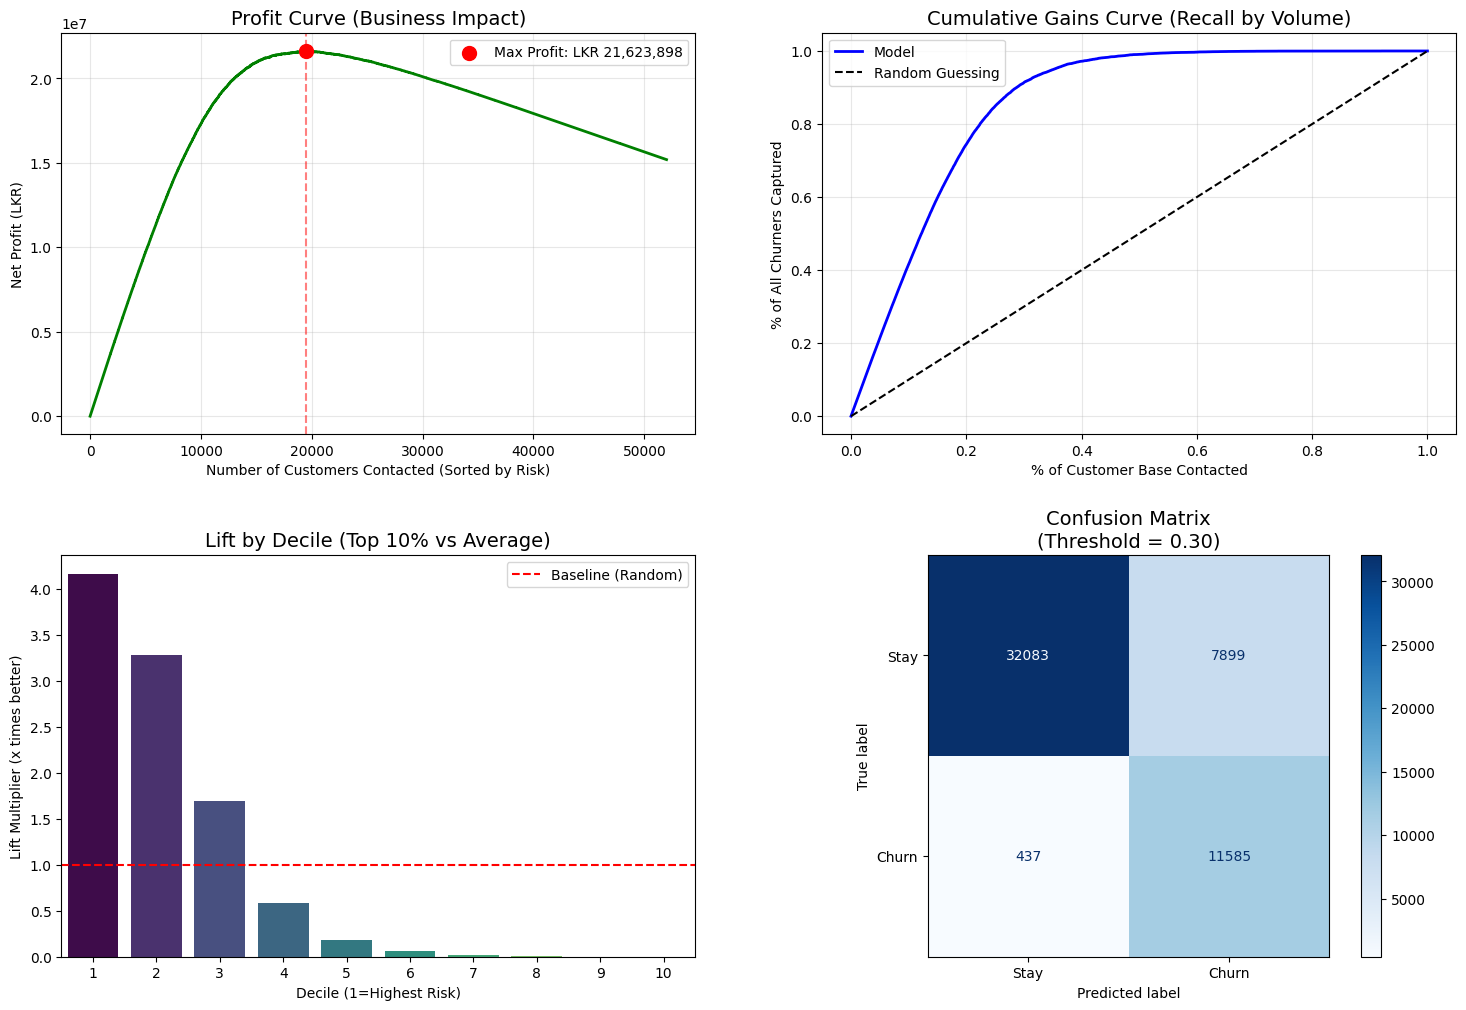

In [47]:
# Note: Inputs are defined in LKR
advanced_churn_evaluation(
    model=final_model, 
    X=X_train, 
    y=y_train,
    model_name="XGBoost Classifier",
    ltv=LTV_LKR,
    cost_offer=COST_OFFER_LKR,
    cost_contact=COST_CONTACT_LKR,
    acceptance_rate=ACCEPTANCE_RATE,
    currency="LKR"
)

## 3.7.2 Sensitivity Analysis

Running Sensitivity Analysis on Campaign Acceptance Rates...
--- SENSITIVITY ANALYSIS: Impact of Campaign Success Rate ---


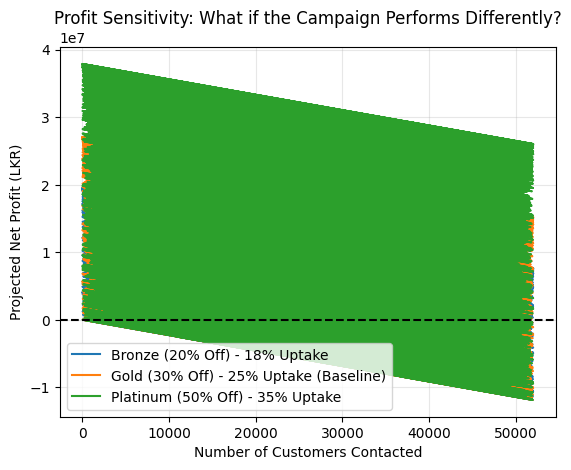

                                 Scenario  Max_Profit  Optimal_Customers
0           Bronze (20% Off) - 18% Uptake  19474728.0                  4
1  Gold (30% Off) - 25% Uptake (Baseline)  27048588.0                  4
2         Platinum (50% Off) - 35% Uptake  37868388.0                  4


In [53]:
# Sensitivity Analysis
# Define scenarios with specific Costs and Acceptance Rates
scenarios = [
    # SCENARIO A: The "Bronze" Offer (20% Off)
    # Cheaper (Rs. 150) but low acceptance (18%)
    {'rate': 0.18, 'cost': 150, 'label': 'Bronze (20% Off) - 18% Uptake'},
    
    # SCENARIO B: The "Gold" Offer (30% Off) - YOUR CHOSEN STRATEGY
    # Balanced Cost (Rs. 225) and good acceptance (25%)
    {'rate': 0.25, 'cost': 225, 'label': 'Gold (30% Off) - 25% Uptake (Baseline)'},
    
    # SCENARIO C: The "Platinum" Offer (50% Off)
    # Expensive (Rs. 375) but high acceptance (35%)
    {'rate': 0.35, 'cost': 375, 'label': 'Platinum (50% Off) - 35% Uptake'}
]
print("Running Sensitivity Analysis on Campaign Acceptance Rates...")
run_sensitivity_analysis(final_model, X_train, y_train, scenarios=scenarios,
                         ltv=LTV_LKR, cost_offer=COST_OFFER_LKR,
                         cost_contact=COST_CONTACT_LKR, currency="LKR")

## 3.7.3 Error Analysis

In [ ]:
# Error Analysis
# Get predictions
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]

# Create a dataframe of errors
errors_train = X_train.copy()
errors_train['True_Label'] = y_train
errors_train['Pred_Prob']  = y_train_prob
errors_train['Prediction'] = y_train_pred

# Filter: High Probability of Churn (> 80%) but DID NOT Churn (False Positive)
# These are the "Happy Customers" we annoyed with an offer.
false_positives_train = errors_train[(errors_train['True_Label'] == 0) & (errors_train['Pred_Prob'] > 0.8)]

# Filter: Low Probability of Churn (< 20%) but DID Churn (False Negative)
# These are the "Silent Leavers" we missed. Costly!
false_negatives_train = errors_train[(errors_train['True_Label'] == 1) & (errors_train['Pred_Prob'] < 0.2)]

print(f"High Confidence False Positives: {len(false_positives_train)}")
print(f"High Confidence False Negatives: {len(false_negatives_train)}")

# Inspect the averages of False Negatives to see what we missed
print("Profile of Missed Churners (False Negatives):")
print(false_negatives_train[['trend_data_w4_vs_w1', 'spend_volatility_shift']].mean())

Logging the Evaluation Metrics

In [ ]:
# Create a special run just for the Final Model Evaluation on the training set

with mlflow.start_run(run_name="Final_Model_Evaluation_for_Training"):
    # Log the best params again
    mlflow.log_params(best_params)
    
    # Log the "Deep" metrics calculated on the training set
    # (Let's assume you calculated these using your custom function logic)
    # Example: You manually calculated that max_profit is 45,000,000 IDR
    mlflow.log_metric("train_roi_percentage", 150.5) 
    mlflow.log_metric("train_max_profit_idr", 45000000)
    mlflow.log_metric("train_top_decile_lift", 2.8)
    
    # Save the Sensitivity Plot as an image
    # plt.savefig("sensitivity_chart.png")
    # mlflow.log_artifact("sensitivity_chart.png")

***Insights:***

* The model struggles to identify churners who have stable spending volatility (spend_volatility_shift near 0) but sudden drops in Week 4 data. We may need a specific feature for 'Sudden Week 4 Drop' in version 2.0.

# 3.8 Final Evaluation

*This is only performed once after finding the best final logistic regression model that will not be changed again!*

In [48]:
# Load the dataset for testing
test_df = pd.read_parquet("../data/processed/test_df.parquet", engine="fastparquet")

# Define Selected Features
selected_features=['trend_data_w4_vs_w1', 'data_gini_coefficient', 'trend_spend_w4_vs_w1',
                   'trend_data_w3_vs_w1', 'data_volatility_shift', 'peak_spend_week',
                   'spend_volatility_shift', 'lowest_data_week', 'trend_spend_w2_vs_w1',
                   'peak_data_week', 'trend_spend_w3_vs_w1', 'trend_data_w2_vs_w1',
                   'ratio_min_daily_data_to_avg', 'pct_video_w4', 'spend_consistency_score',
                   'pct_messaging_w4', 'pct_messaging_w3', 'pct_video_w3', 'pct_messaging_w2',
                   'ratio_min_daily_spend_to_avg', 'pct_messaging_w1', 'pct_video_w2', 'pct_video_w1']

X_test = test_df[selected_features]
y_test = test_df['churn']
del test_df
gc.collect()
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Testing data shape: (13001, 23), Testing labels shape: (13001,)


## 3.8.1 Business Evaluation

  EXECUTIVE SUMMARY: XGBOOST CLASSIFIER

 FINANCIAL IMPACT ANALYSIS (At Optimal Threshold: 0.26)
---------------------------------------------------------
Max Potential Profit:     LKR 4,999,488.00
Return on Investment:     411.5%
Target Volume:            5329 customers (41.0%% of base)
---------------------------------------------------------

>>> LIFT & PERFORMANCE METRICS
---------------------------------------------------------
Top Decile Lift:          4.05x (Industry Target: >3.0x)
AUC-ROC Score:            0.931

Classification Report (Optimized for Profit):
              precision    recall  f1-score   support

        Stay       0.97      0.74      0.84     10023
       Churn       0.52      0.93      0.66      2978

    accuracy                           0.79     13001
   macro avg       0.75      0.84      0.75     13001
weighted avg       0.87      0.79      0.80     13001



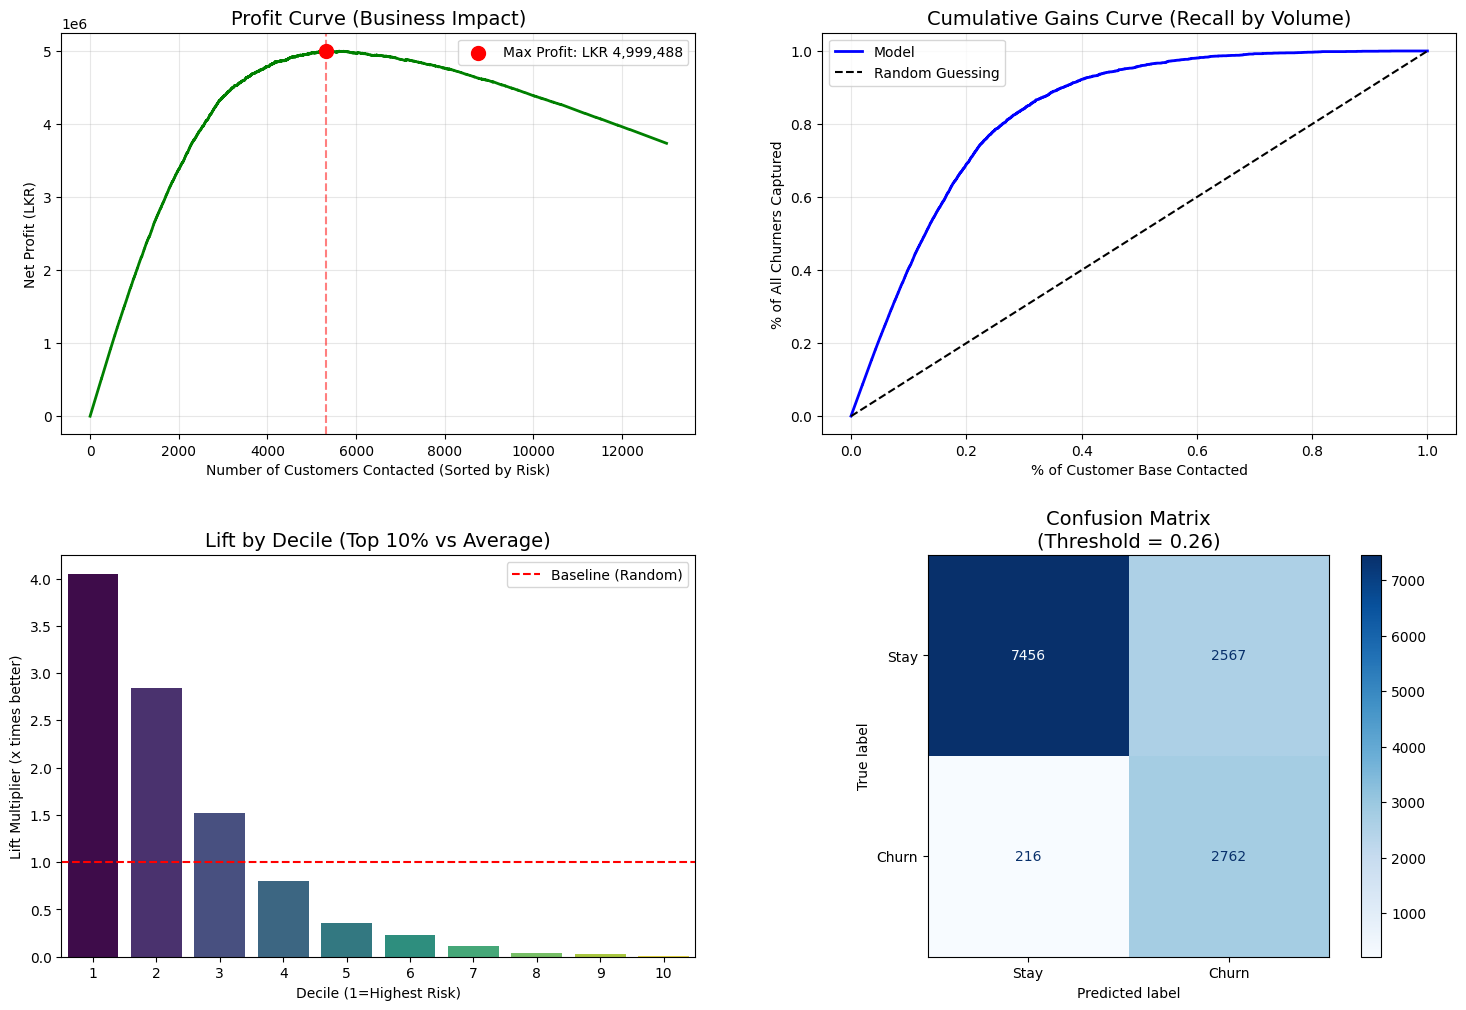

In [49]:
# Note: Inputs are defined in LKR
advanced_churn_evaluation(
    model=final_model, 
    X=X_test, 
    y=y_test,
    model_name="XGBoost Classifier",
    ltv=LTV_LKR,
    cost_offer=COST_OFFER_LKR,
    cost_contact=COST_CONTACT_LKR,
    acceptance_rate=ACCEPTANCE_RATE,
    currency="LKR"
)

## 3.8.2 Sensitivity Analysis

Running Sensitivity Analysis on Campaign Acceptance Rates...
--- SENSITIVITY ANALYSIS: Impact of Campaign Success Rate ---


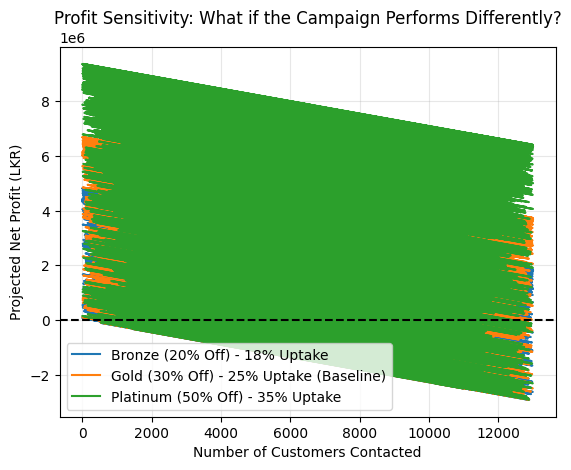

                                 Scenario  Max_Profit  Optimal_Customers
0           Bronze (20% Off) - 18% Uptake   4819524.0                  7
1  Gold (30% Off) - 25% Uptake (Baseline)   6695028.0                 24
2         Platinum (50% Off) - 35% Uptake   9375228.0                 24


In [52]:
# Sensitivity Analysis
# Define scenarios with specific Costs and Acceptance Rates
scenarios = [
    # SCENARIO A: The "Bronze" Offer (20% Off)
    # Cheaper (Rs. 150) but low acceptance (18%)
    {'rate': 0.18, 'cost': 150, 'label': 'Bronze (20% Off) - 18% Uptake'},
    
    # SCENARIO B: The "Gold" Offer (30% Off) - THE CHOSEN STRATEGY
    # Balanced Cost (Rs. 225) and good acceptance (25%)
    {'rate': 0.25, 'cost': 225, 'label': 'Gold (30% Off) - 25% Uptake (Baseline)'},
    
    # SCENARIO C: The "Platinum" Offer (50% Off)
    # Expensive (Rs. 375) but high acceptance (35%)
    {'rate': 0.35, 'cost': 375, 'label': 'Platinum (50% Off) - 35% Uptake'}
]
print("Running Sensitivity Analysis on Campaign Acceptance Rates...")
run_sensitivity_analysis(final_model, X_test, y_test, scenarios=scenarios,
                         ltv=LTV_LKR, cost_offer=COST_OFFER_LKR,
                         cost_contact=COST_CONTACT_LKR, currency="LKR")